# 06. Sentinel-6 MF L2 Altimetry Data Access (OPeNDAP) & Gridding

In this tutorial you will learn...

1. about level 2 radar altimetry data from the Sentinel-6 Michael Freilich mission;
2. how to efficiently download variable subsets using OPeNDAP;
3. how to grid the along-track altimetry observations produced by S6 at level 2.;

### About Ocean Surface Topography (OST)

<img src="https://podaac.jpl.nasa.gov/sites/default/files/content/PO.DAAC_SAT_Timeline_high_res.jpg" width="60%">

The primary contribution of satellite altimetry to satellite oceanography has been to:

* Improve the knowledge of ocean tides and develop global tide models.
* Monitor the variation of global mean sea level and its relationship to changes in ocean mass and heat content.
* Map the general circulation variability of the ocean, including the ocean mesoscale, over decades and in near real-time using multi-satellite altimetric sampling.

### About Sentinel-6 MF

https://search.earthdata.nasa.gov/search?fpj=Sentinel-6

<img src="https://sealevel.jpl.nasa.gov/system/downloadable_items/348_Image13-Sentinel6-1000.jpg" width="55%">

https://podaac.jpl.nasa.gov/Sentinel-6

#### Mission Characteristics

```yaml
Semi-major axis: 7,714.43 km
Eccentricity: 0.000095
Inclination: 66.04°
Argument of periapsis: 90.0°
Mean anomaly: 253.13°
Reference altitude: 1,336 km
Nodal period: 6,745.72 sec
Repeat period: 9.9156 days
Number of revolutions within a cycle: 127
Number of passes within a cycle: 254
Equatorial cross track separation: 315 km
Ground track control band: +1 km
Acute angle at Equator crossings: 39.5°
Ground track speed: 5.8 km/s
```

### Requirements

This workflow was developed using Python 3.9 (and tested against versions 3.7, 3.8).

In [1]:
import os
import tqdm
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from pyresample.kd_tree import resample_gauss
import pyresample as pr

### Dataset

https://podaac.jpl.nasa.gov/dataset/JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F

This example operates on Level 2 Low Resolution Altimetry from Sentinel-6 Michael Freilich (the Near Real Time Reduced distribution). It is most easily identified by its collection *ShortName*, given below with the more cryptic *concept-id*, it's unique identifier in the CMR.

In [2]:
ShortName = 'JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F'
concept_id = 'C1968980576-POCLOUD'

<img src="https://podaac.jpl.nasa.gov/Podaac/thumbnails/JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F.jpg" width="80%">

#### OPeNDAP

https://opendap.github.io/documentation/UserGuideComprehensive.html#Constraint_Expressions (Hyrax/OPeNDAP docs)    

How to get the list of opendap endpoints hard-coded in the following cell:

```ipython
cycle = 25

url = f"https://cmr.earthdata.nasa.gov/search/granules.csv?ShortName={ShortName}&cycle={cycle}&page_size=200"

!curl --silent --output "results.csv" "$url"

files = !cat results.csv | tail --lines=+2 | cut --delimiter=',' --field=5 | cut --delimiter='/' --field=6

variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha']

v = ",".join(variables)

for f in files:
    print(f"https://opendap.earthdata.nasa.gov/collections/{concept_id}/granules/{f}4?{v}")
```

In [24]:
cycle = 25

url = f"https://cmr.earthdata.nasa.gov/search/granules.csv?ShortName={ShortName}&cycle={cycle}&page_size=200"

!curl --silent --output "results.csv" "$url"

files = !cat results.csv | tail --lines=+2 | cut --delimiter=',' --field=5 | cut --delimiter='/' --field=6

variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha']

v = ",".join(variables)

for f in files:
    print(f"https://opendap.earthdata.nasa.gov/collections/{concept_id}/granules/{f}4?{v}")

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_003_20210713T182234_20210713T201839_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_006_20210713T201839_20210713T215450_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_007_20210713T215450_20210713T234732_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_009_20210713T234732_20210714T014224_F02.nc4?data_01_time,data_0

In [3]:
%%file subsets.txt
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_003_20210713T182234_20210713T201839_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_006_20210713T201839_20210713T215450_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_007_20210713T215450_20210713T234732_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_009_20210713T234732_20210714T014224_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_011_20210714T014224_20210714T033812_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_013_20210714T033812_20210714T053356_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_015_20210714T053357_20210714T072934_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_017_20210714T072934_20210714T090919_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_019_20210714T090919_20210714T110146_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_021_20210714T110146_20210714T125702_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_023_20210714T125702_20210714T145316_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_025_20210714T145317_20210714T164922_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_027_20210714T164922_20210714T184510_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_029_20210714T184510_20210714T204143_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_032_20210714T204143_20210714T221611_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_033_20210714T221611_20210715T000941_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_035_20210715T000941_20210715T020456_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_037_20210715T020456_20210715T040047_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_039_20210715T040047_20210715T055630_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_041_20210715T055630_20210715T075208_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_043_20210715T075208_20210715T093037_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_045_20210715T093037_20210715T112356_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_047_20210715T112356_20210715T131944_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_049_20210715T131944_20210715T151600_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_051_20210715T151602_20210715T165851_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_053_20210715T171228_20210715T190748_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_056_20210715T190748_20210715T204627_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_057_20210715T204627_20210715T223758_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_059_20210715T223758_20210716T003159_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_061_20210716T003159_20210716T022732_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_063_20210716T022732_20210716T042333_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_065_20210716T042333_20210716T061901_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_067_20210716T061901_20210716T081446_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_070_20210716T081446_20210716T095203_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_071_20210716T095203_20210716T114624_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_073_20210716T114624_20210716T134228_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_075_20210716T134228_20210716T153841_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_077_20210716T153841_20210716T173433_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_079_20210716T173433_20210716T193033_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_082_20210716T193033_20210716T210718_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_083_20210716T210718_20210716T225942_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_085_20210716T225942_20210717T005425_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_087_20210717T005425_20210717T025012_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_089_20210717T025012_20210717T044557_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_091_20210717T044557_20210717T064133_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_093_20210717T064133_20210717T082134_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_095_20210717T082134_20210717T101352_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_097_20210717T101352_20210717T120859_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_099_20210717T120859_20210717T140513_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_101_20210717T140513_20210717T160120_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_103_20210717T160120_20210717T175708_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_105_20210717T175708_20210717T195329_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_108_20210717T195329_20210717T212832_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_109_20210717T212832_20210717T232147_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_111_20210717T232147_20210718T011655_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_113_20210718T011655_20210718T031245_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_115_20210718T031245_20210718T050829_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_117_20210718T050829_20210718T070406_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_119_20210718T070406_20210718T084306_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_121_20210718T084306_20210718T103559_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_123_20210718T103559_20210718T123140_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_125_20210718T123140_20210718T142756_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_127_20210718T142756_20210718T162356_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_129_20210718T162356_20210718T181945_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_132_20210718T181945_20210718T195907_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_133_20210718T195907_20210718T215014_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_135_20210718T215014_20210718T234402_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_137_20210718T234402_20210719T013937_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_139_20210719T013937_20210719T033531_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_141_20210719T033531_20210719T053101_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_143_20210719T053101_20210719T072643_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_146_20210719T072643_20210719T090425_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_147_20210719T090425_20210719T105824_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_149_20210719T105824_20210719T125424_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_151_20210719T125424_20210719T145038_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_153_20210719T145541_20210719T164632_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_155_20210719T164632_20210719T184227_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_158_20210719T184227_20210719T201949_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_159_20210719T201949_20210719T221154_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_161_20210719T221154_20210720T000626_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_163_20210720T000626_20210720T020212_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_165_20210720T020212_20210720T035756_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_167_20210720T035756_20210720T055333_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_169_20210720T055333_20210720T073350_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_171_20210720T073350_20210720T092602_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_173_20210720T092602_20210720T112057_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_175_20210720T112057_20210720T131708_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_177_20210720T131708_20210720T151317_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_184_20210720T190549_20210720T204056_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_185_20210720T204056_20210720T223355_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_187_20210720T223355_20210721T002855_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_189_20210721T002855_20210721T022443_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_191_20210721T022443_20210721T042029_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_193_20210721T042029_20210721T061605_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_195_20210721T061605_20210721T075531_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_197_20210721T075531_20210721T094805_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_199_20210721T094805_20210721T114336_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_201_20210721T114336_20210721T133952_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_203_20210721T133952_20210721T153555_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_205_20210721T153555_20210721T173143_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_207_20210721T173143_20210721T191151_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_209_20210721T191151_20210721T210223_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_211_20210721T210223_20210721T225607_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_213_20210721T225607_20210722T005131_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_215_20210722T005131_20210722T024724_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_217_20210722T024724_20210722T044301_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_219_20210722T044301_20210722T063841_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_221_20210722T063841_20210722T081646_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_223_20210722T081646_20210722T101025_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_225_20210722T101025_20210722T120619_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_227_20210722T120619_20210722T140235_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_229_20210722T140235_20210722T155831_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_231_20210722T155831_20210722T175423_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_234_20210722T175423_20210722T193222_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_235_20210722T193222_20210722T212406_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_237_20210722T212406_20210722T231828_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_239_20210722T231828_20210723T011405_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_241_20210723T011405_20210723T030955_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_243_20210723T030955_20210723T050533_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_245_20210723T050533_20210723T064603_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_247_20210723T064603_20210723T083817_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_249_20210723T083817_20210723T103256_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_251_20210723T103256_20210723T122904_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha
https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_253_20210723T122904_20210723T142514_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha

Writing subsets.txt


In [26]:
with open ("subsets.txt", "r") as f:
    f.read().split("/n")[:-1]
                   
len(urls), urls[0]


(125,
 'https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha')

In [4]:
cycle = 25

url = f"https://cmr.earthdata.nasa.gov/search/granules.csv?ShortName={ShortName}&cycle={cycle}&page_size=200"

print(url)

https://cmr.earthdata.nasa.gov/search/granules.csv?ShortName=JASON_CS_S6A_L2_ALT_LR_RED_OST_NRT_F&cycle=25&page_size=200


In [5]:
!curl --silent --output "results.csv" "$url"

files = !cat results.csv | tail --lines=+2 | cut --delimiter=',' --fields=5 | cut --delimiter='/' --fields=6

print(files.s.replace(" ", "\n"))

S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc
S6A_P4_2__LR_RED__NR_025_003_20210713T182234_20210713T201839_F02.nc
S6A_P4_2__LR_RED__NR_025_006_20210713T201839_20210713T215450_F02.nc
S6A_P4_2__LR_RED__NR_025_007_20210713T215450_20210713T234732_F02.nc
S6A_P4_2__LR_RED__NR_025_009_20210713T234732_20210714T014224_F02.nc
S6A_P4_2__LR_RED__NR_025_011_20210714T014224_20210714T033812_F02.nc
S6A_P4_2__LR_RED__NR_025_013_20210714T033812_20210714T053356_F02.nc
S6A_P4_2__LR_RED__NR_025_015_20210714T053357_20210714T072934_F02.nc
S6A_P4_2__LR_RED__NR_025_017_20210714T072934_20210714T090919_F02.nc
S6A_P4_2__LR_RED__NR_025_019_20210714T090919_20210714T110146_F02.nc
S6A_P4_2__LR_RED__NR_025_021_20210714T110146_20210714T125702_F02.nc
S6A_P4_2__LR_RED__NR_025_023_20210714T125702_20210714T145316_F02.nc
S6A_P4_2__LR_RED__NR_025_025_20210714T145317_20210714T164922_F02.nc
S6A_P4_2__LR_RED__NR_025_027_20210714T164922_20210714T184510_F02.nc
S6A_P4_2__LR_RED__NR_025_029_20210714T184510_202

In [ ]:
tmp = files.l[0].split('.')[0]

print(f"https://opendap.earthdata.nasa.gov/collections/{concept_id}/granules/{tmp}.html")

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.html


In [7]:
variables = ['data_01_time',
             'data_01_longitude',
             'data_01_latitude',
             'data_01_ku_ssha']

In [8]:
v = ",".join(variables)

urls = []
for f in files:
    urls.append(f"https://opendap.earthdata.nasa.gov/collections/{concept_id}/granules/{f}4?{v}")

print(urls[0])

https://opendap.earthdata.nasa.gov/collections/C1968980576-POCLOUD/granules/S6A_P4_2__LR_RED__NR_025_001_20210713T162644_20210713T182234_F02.nc4?data_01_time,data_01_longitude,data_01_latitude,data_01_ku_ssha


### Download Subsets

These functions download one granule from the remote `source` to a local `target`, and will reliably manage simultaneous streaming downloads divided between multiple threads.

##### with python3:

```python
import requests

def download(source: str, target: str):
    with requests.get(source, stream=True) as remote, open(target, 'wb') as local:
        if remote.status_code // 100 == 2: 
            for chunk in remote.iter_content(chunk_size=1024):
                if chunk:
                    local.write(chunk)
```

##### with wget:

In [9]:
def download(source: str):
    
    target = os.path.basename(source.split("?")[0])
    
    if not os.path.isfile(target):
        !wget --quiet --continue --output-document $target $source
    
    return target

In [10]:
n_workers = 12

with ThreadPoolExecutor(max_workers=n_workers) as pool:

    workers = pool.map(download, urls)
    
    files = list(tqdm.tqdm(workers, total=len(urls)))

100%|██████████| 125/125 [01:11<00:00,  1.74it/s]


https://docs.python.org/3/library/concurrent.futures.html#threadpoolexecutor    

The source files range from 2.5MB to 3.0MB. These OPeNDAP subsets are ~100KB apiece. (anecdote: it took less than 10 minutes to download subsets for >1700 granules/files when I ran this routine for all cycles going back to 2021-06-22.)

In [27]:
!du -sh .

25M	.


https://www.gnu.org/software/coreutils/manual/html_node/du-invocation.html    

#### Aggregate cycle

Sort the list of local subsets to ensure they concatenate in proper order. Call `open_mfdataset` on the list to open all the subsets in memory as one dataset in xarray.

In [12]:
ds = xr.open_mfdataset(sorted(files))

print(ds)

<xarray.Dataset>
Dimensions:            (data_01_time: 827001)
Coordinates:
  * data_01_time       (data_01_time) datetime64[ns] 2021-07-13T16:26:45 ... ...
Data variables:
    data_01_longitude  (data_01_time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    data_01_latitude   (data_01_time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
    data_01_ku_ssha    (data_01_time) float64 dask.array<chunksize=(6950,), meta=np.ndarray>
Attributes: (12/63)
    Convention:                             CF-1.7
    institution:                            EUMETSAT
    references:                             Sentinel-6_Jason-CS ALT Generic P...
    contact:                                ops@eumetsat.int
    radiometer_sensor_name:                 AMR-C
    doris_sensor_name:                      DORIS
    ...                                     ...
    xref_solid_earth_tide:                  S6__P4_2__SETD_AX_20151008T000000...
    xref_surface_classification:            S6__P4___

In [29]:
files[25]


'S6A_P4_2__LR_RED__NR_025_051_20210715T151602_20210715T165851_F02.nc'

https://xarray.pydata.org/en/stable/generated/xarray.open_mfdataset.html    

Make a dictionary to rename variables so that the `data_01_` prefix is removed from each one.

In [13]:
new_variable_names = list(map(lambda x: x.split("_")[-1], variables))

map_variable_names = dict(zip(variables, new_variable_names))

map_variable_names

{'data_01_time': 'time',
 'data_01_longitude': 'longitude',
 'data_01_latitude': 'latitude',
 'data_01_ku_ssha': 'ssha'}

In [30]:
list(ds.variables)

['longitude', 'latitude', 'ssha', 'time']

https://docs.python.org/3/library/functions.html#map    
https://docs.python.org/3/library/functions.html#zip    

In [14]:
ds = ds.rename(map_variable_names)

print(list(ds.variables))

['longitude', 'latitude', 'ssha', 'time']


#### Plot *ssha* variable

https://xarray.pydata.org/en/stable/generated/xarray.Dataset.rename.html  

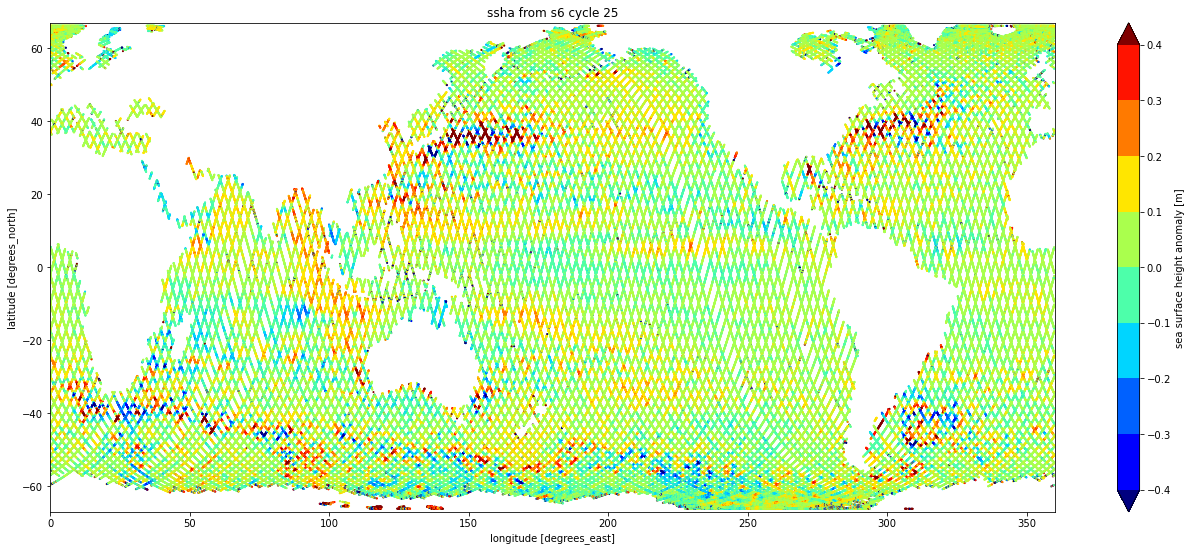

In [15]:
ds.plot.scatter( y="latitude",
                 x="longitude", 
                 hue="ssha",
                 s=1,
                 vmin=-0.4,
                 vmax=0.4,
                 levels=9, 
                 cmap="jet",
                 aspect=2.5,
                 size=9, )

plt.title(f"ssha from s6 cycle {cycle}")
plt.xlim(  0., 360.)
plt.ylim(-67.,  67.)
plt.show()

### Borrow 0.5-Degree Grid and Mask from ECCO V4r4 

>***Acknowledgement**: This approach using [*pyresample*](https://pyresample.readthedocs.io/en/latest/api/pyresample)       was shared to me by Ian Fenty, ECCO Lead.*

https://search.earthdata.nasa.gov/search/granules?p=C2013583732-POCLOUD

ECCO V4r4 products are distributed in two spatial formats. One set of collections provides the ocean state estimates on the native model grid (LLC0090) and the other provides them after interpolating to a regular grid defined in geographic coordinates with horizontal cell size of 0.5-degrees.

It's distributed as its own dataset/collection containing just one file. We can simply download it from the HTTPS download endpoint -- the file size is inconsequential. The next cell downloads the file into the *data* folder from the granule's https endpoint.

In [16]:
ecco_url = "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_GEOMETRY_05DEG_V4R4/GRID_GEOMETRY_ECCO_V4r4_latlon_0p50deg.nc"

ecco_file = download(ecco_url)

ecco_grid = xr.open_dataset(ecco_file)

print(ecco_grid)

<xarray.Dataset>
Dimensions:         (Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * Z               (Z) float32 -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
    latitude_bnds   (latitude, nv) float32 ...
    longitude_bnds  (longitude, nv) float32 ...
    Z_bnds          (Z, nv) float32 ...
Dimensions without coordinates: nv
Data variables:
    hFacC           (Z, latitude, longitude) float64 ...
    Depth           (latitude, longitude) float64 ...
    area            (latitude, longitude) float64 ...
    drF             (Z) float32 ...
    maskC           (Z, latitude, longitude) bool ...
Attributes: (12/57)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                     

https://xarray.pydata.org/en/stable/generated/xarray.open_dataset.html   

Select index `0` on the `Z` axis/dimension to get the depth layer at ocean surface.

In [17]:
ecco_grid = ecco_grid.isel(Z=0).copy()

https://xarray.pydata.org/en/stable/generated/xarray.DataArray.isel.html    

The `maskC` variable contains a boolean mask representing the wet/dry state of the area contained in each cell of the 3d grid defined by `Z` and `latitude` and `longitude`. Here are the variable's attributes:

In [18]:
print(ecco_grid.maskC)

<xarray.DataArray 'maskC' (latitude: 360, longitude: 720)>
[259200 values with dtype=bool]
Coordinates:
    Z          float32 -5.0
  * latitude   (latitude) float32 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float32 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
Attributes:
    coverage_content_type:  modelResult
    long_name:              wet/dry boolean mask for grid cell
    comment:                True for grid cells with nonzero open vertical fr...


Plot the land/water mask `maskC`:

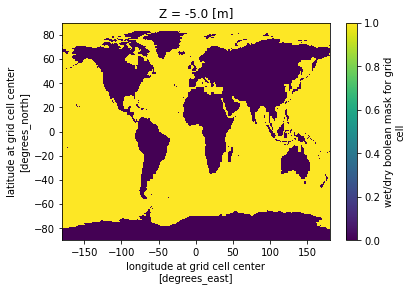

In [19]:
ecco_grid.maskC.plot()

https://xarray.pydata.org/en/stable/generated/xarray.DataArray.plot.html    

Define target grid based on the longitudes and latitudes from the ECCO grid geometry dataset. This time define the grid using two 2-dimensional arrays that give positions of all SSHA values in geographic/longitude-latitude coordinates.

In [20]:
ecco_lons = ecco_grid.maskC.longitude.values
ecco_lats = ecco_grid.maskC.latitude.values

ecco_lons_2d, ecco_lats_2d = np.meshgrid(ecco_lons, ecco_lats)

print(ecco_lons_2d.shape, ecco_lats_2d.shape)

(360, 720) (360, 720)


Create the target swath definition from the 2d arrays of lons and lats from ECCO V4r4 0.5-degree grid.

In [21]:
tgt = pr.SwathDefinition(ecco_lons_2d, ecco_lats_2d)

[pyresample.geometry.SwathDefinition](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.geometry.SwathDefinition)    

### Grid ssha or other variable

Get one timestamp to represent the midpoint of the 10-day cycle.

In [22]:
time = np.datetime64(ds['time'].mean().data)

print(time)

2021-07-18T15:11:35.073955170


Access the target variable, *ssha* in this case. Make a nan mask from the ssha variable.

In [23]:
nans = ~np.isnan(ds.ssha.values)

ssha = ds.ssha.values[nans]

ssha.shape

(518164,)

Create the source swath definition from the 1d arrays of lons and lats from the S6 level-2 along-track altimetry time series.

In [31]:
lons = ds.longitude.values[nans]
lats = ds.latitude.values[nans]
        
print(lons.shape, lats.shape)

(518164,) (518164,)


In [32]:
lons = (lons + 180) % 360 - 180

src = pr.SwathDefinition(lons, lats)

[pyresample.geometry.SwathDefinition](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.geometry.SwathDefinition)    

Resample *ssha* data using kd-tree gaussian weighting neighbour approach.

In [33]:
result, stddev, counts = resample_gauss(
    src,
    ssha,
    tgt,
    radius_of_influence=175000,  
    sigmas=25000,
    neighbours=100,
    fill_value=np.nan,
    with_uncert=True,
)

result.shape

/srv/conda/envs/notebook/lib/python3.9/site-packages/pyresample/kd_tree.py:384: UserWarning: Possible more than 100 neighbours within 175000 m for some data points
  warnings.warn(('Possible more than %s neighbours '


(360, 720)

[pyresample.kd_tree.resample_gauss](https://pyresample.readthedocs.io/en/latest/api/pyresample.html#pyresample.kd_tree.resample_gauss)    

In [34]:
def to_xrda(data):
    return xr.DataArray(data,
                        dims=['latitude', 'longitude'], 
                        coords={'time': time, 
                                'latitude': ecco_lats, 
                                'longitude': ecco_lons})

Apply the land/water mask in the numpy array created from the ECCO layer in the steps above. Then, convert the masked numpy array to an xarray data array object named *gridded*. Print its header.

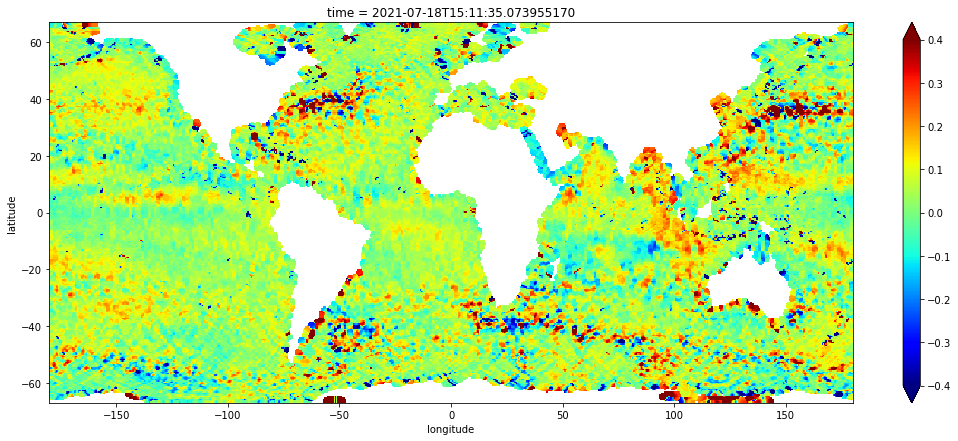

In [35]:
grid = to_xrda(result)

grid.sel(latitude=slice(-67.0, 67.0)).plot(vmin=-0.4, vmax=0.4, cmap="jet", figsize=(18, 7))

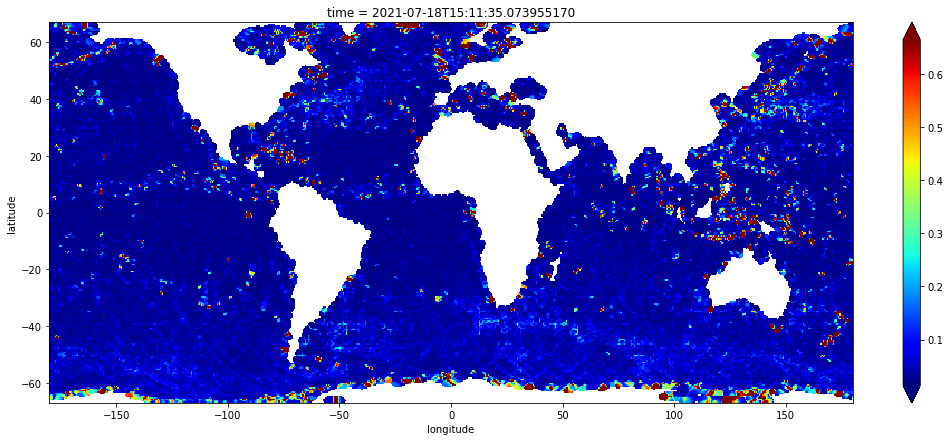

In [36]:
stddev = to_xrda(stddev)

stddev.sel(latitude=slice(-67.0, 67.0)).plot(robust=True, cmap="jet", figsize=(18, 7))

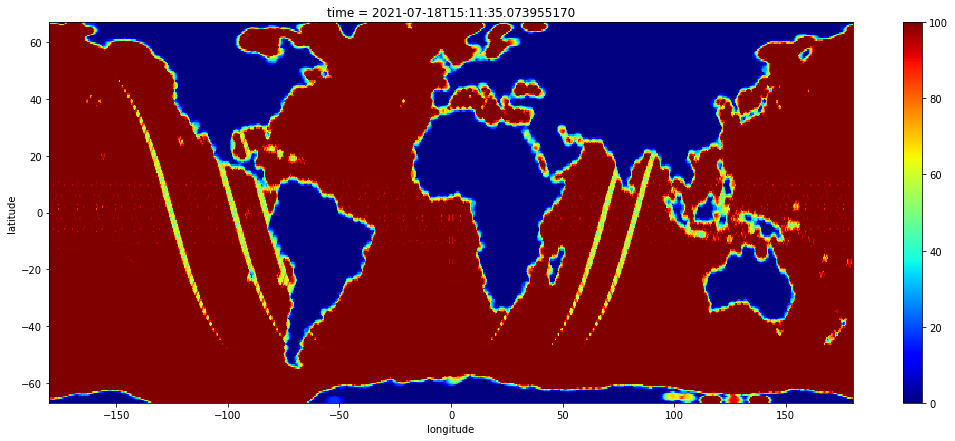

In [37]:
counts = to_xrda(counts)

counts.sel(latitude=slice(-67.0, 67.0)).plot(robust=True, cmap="jet", figsize=(18, 7))

### Exercise

Calculate area-weighted mean sea level.

### References

*numpy* (https://numpy.org/doc/stable/reference)    

* [numpy.ndarray.data](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.data.html)      
* [numpy.where](https://numpy.org/doc/stable/reference/generated/numpy.where.html)    
* [numpy.isnan](https://numpy.org/doc/stable/reference/generated/numpy.isnan.html)    
* [datetimes](https://numpy.org/doc/stable/reference/arrays.datetime.html)    
* [numpy.sum](https://numpy.org/doc/stable/reference/generated/numpy.sum.html)    
* [numpy.nansum](https://numpy.org/doc/stable/reference/generated/numpy.nansum.html)    

*xarray* (https://xarray.pydata.org/en/stable)    

* [xarray.DataArray](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.html)    
* [xarray.DataArray.values](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.values.html)    
* [xarray.DataArray.mean](https://xarray.pydata.org/en/stable/generated/xarray.DataArray.mean.html)    